In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

# Keras documentation can be found on keras.io:
import tensorflow.keras
from tensorflow.keras.datasets import mnist      # NOTE: This loads the data!
# manual link to data:  http://yann.lecun.com/exdb/mnist/
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Load and prepare the MNIST dataset

In [13]:
MetaData = pd.read_csv("./train/train.csv")
data = np.load('data_codingset_ash.npz')
data2 = np.load('data_codingset_pollen.npz')



#print(data['label'])
data_ash = np.array(data['data_ash'])
meta_ash = MetaData['Area (ABD)'][MetaData['camp']==1][:500].values
meta_ash = np.hstack((  meta_ash  ,  MetaData['Area (ABD)'][MetaData['grim']==1][:500].values  ))

label = np.array(data['label'])[0]

data_pollen = np.array( data2['data_pollen'][:100] )




#print(np.array(data['label'])[0])

print(data_ash.shape)
print(data_pollen.shape)

#plt.imshow(val_images[0])
print(meta_ash.shape)

(1000, 256, 256)
(100, 256, 256)
(1000,)


In [20]:
train_images, rest_images, train_label, rest_label = train_test_split(data_ash, label, test_size=0.4, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(rest_images, rest_label, test_size=0.3, random_state=13052020)



# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 256, 256 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 2
train_labels = tensorflow.keras.utils.to_categorical(train_label, num_classes)
val_labels = tensorflow.keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = tensorflow.keras.utils.to_categorical(test_labels, num_classes)

data_pollen = standardizeimg(img=data_pollen, mu=mu_train, sigma=sigma_train)
data_pollen = data_pollen.reshape(data_pollen.shape[0], img_rows, img_cols, 1)


In [21]:
print(sigma_train)

36.770448188628336


In [22]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (600, 256, 256, 1)
 > labels: (600, 2)
Validation set:
 > images: (280, 256, 256, 1)
 > labels: (280, 2)
Test set:
 > images: (120, 256, 256, 1)
 > labels: (120, 2)


# Verify first 5 mages in each split dataset

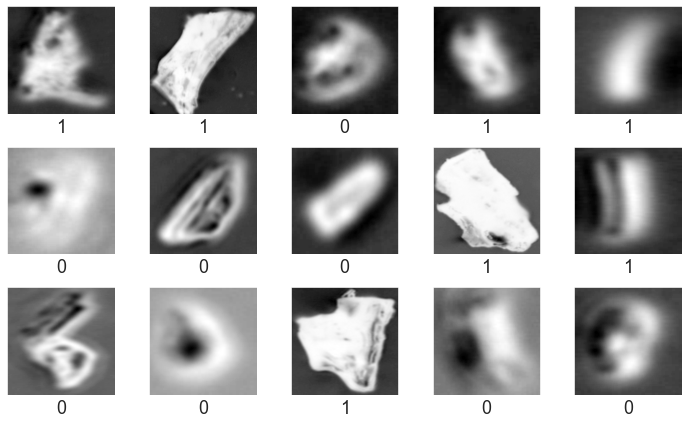

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))

N = 256

for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(N,N), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

# Check for (un)balanced data

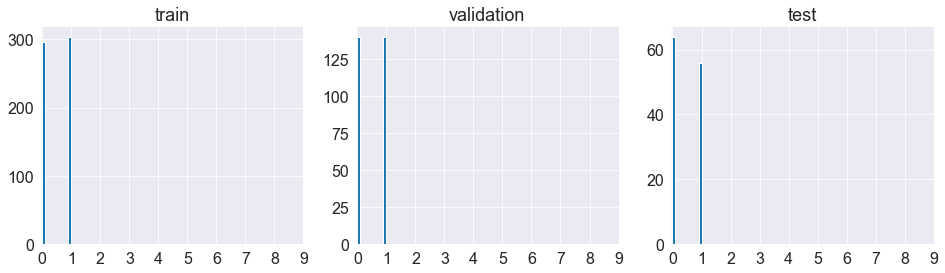

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(10)); ax[0].tick_params(axis='both', which='major', labelsize=16);
ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(10)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(10)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

# Create architecture

See if you can also draw the below architecture, making it clear to others what exactly you've done/used.

In [50]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))


model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())


model.add(Dense(units=256, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

# Compile and train model

In [51]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/5
10/10 [==============================] - 22s 2s/step - loss: 5.8606 - categorical_accuracy: 0.6517 - val_loss: 1.2105 - val_categorical_accuracy: 0.7893
Epoch 2/5
10/10 [==============================] - 21s 2s/step - loss: 0.7287 - categorical_accuracy: 0.7300 - val_loss: 0.7524 - val_categorical_accuracy: 0.7464
Epoch 3/5
10/10 [==============================] - 21s 2s/step - loss: 0.5495 - categorical_accuracy: 0.7000 - val_loss: 0.4439 - val_categorical_accuracy: 0.8179
Epoch 4/5
10/10 [==============================] - 21s 2s/step - loss: 0.4514 - categorical_accuracy: 0.7683 - val_loss: 0.4709 - val_categorical_accuracy: 0.7607
Epoch 5/5
10/10 [==============================] - 22s 2s/step - loss: 0.3901 - categorical_accuracy: 0.8017 - val_loss: 0.4257 - val_categorical_accuracy: 0.8179


In [52]:
extractor = tensorflow.keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])

features_ash = extractor(train_images)
features_pollen = extractor(data_pollen)

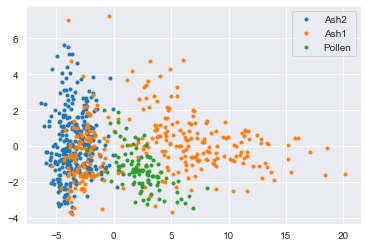

In [61]:


n = -2
pca = PCA(2)

pca.fit(features_ash[n])

pca_0 = pca.transform(  features_ash[n][train_label == 0]  )
pca_1 = pca.transform(  features_ash[n][train_label == 1]  )
pca_2 = pca.transform( features_pollen[n] )

plt.plot(pca_0[:,0],pca_0[:,1],'.', label = 'Ash2')
plt.plot(pca_1[:,0],pca_1[:,1],'.', label = 'Ash1')
plt.plot(pca_2[:,0],pca_2[:,1],'.',label = 'Pollen')
plt.legend()

plt.show()




# Inspect learned kernels

1st convolution layer:


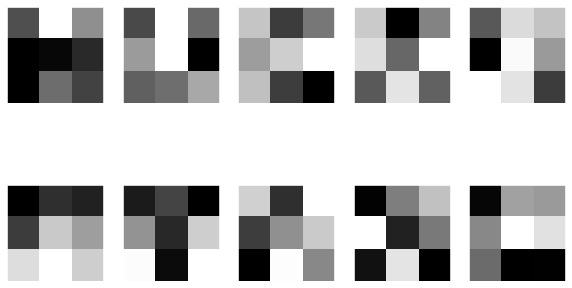

2nd convolution layer:


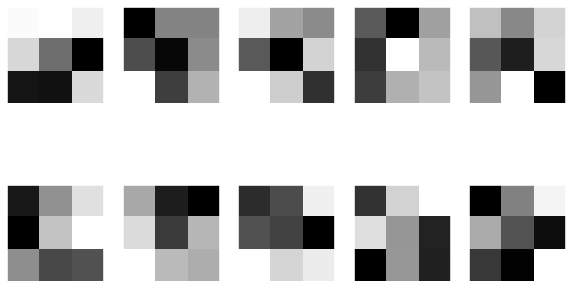

In [54]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Evaluate training process

9/9 - 3s - loss: 0.4257 - categorical_accuracy: 0.8179


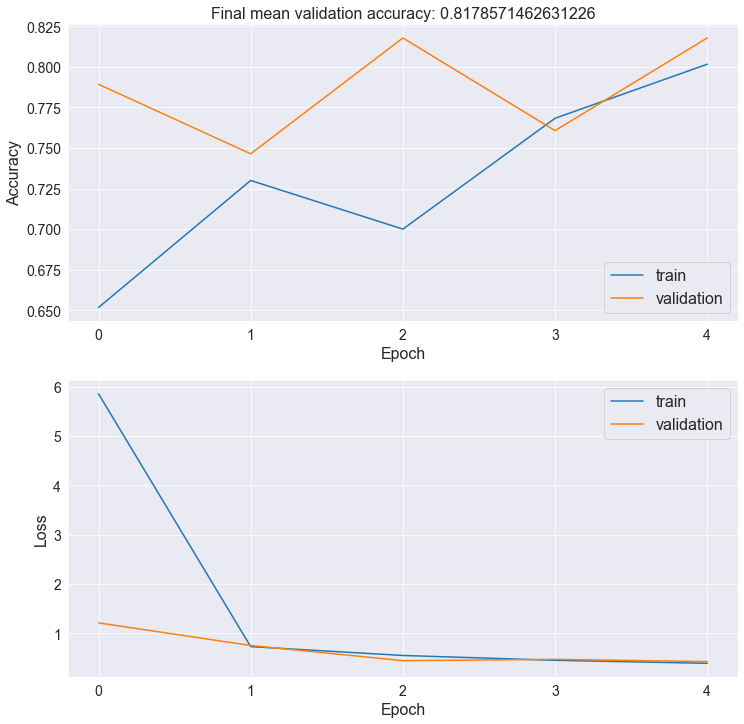

In [55]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

# Inference

In [56]:
# using until now unseen data
predicted_prob = model.predict(test_images)
predictions = np.argmax(predicted_prob, axis=1)

In [57]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1), predictions=predictions, num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate

Confusion Matrix:  tf.Tensor(
[[56  8]
 [18 38]], shape=(2, 2), dtype=int32)


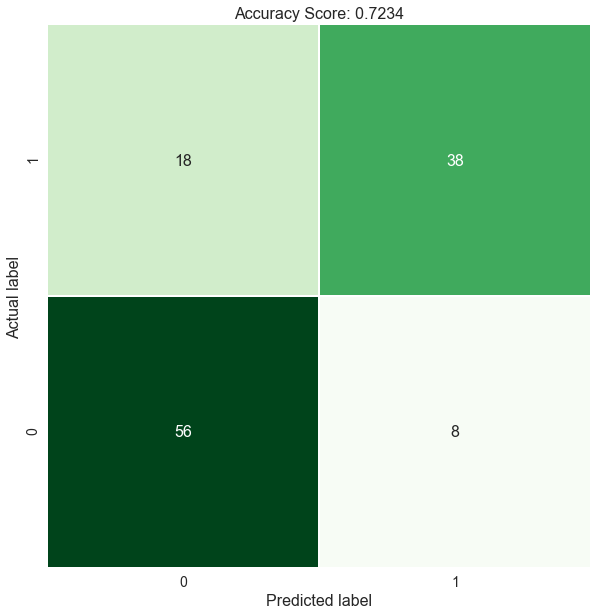

Correct: 94/120
Wrong: 26/120


In [58]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

# Inspection of predictions

### Correctly predicted images

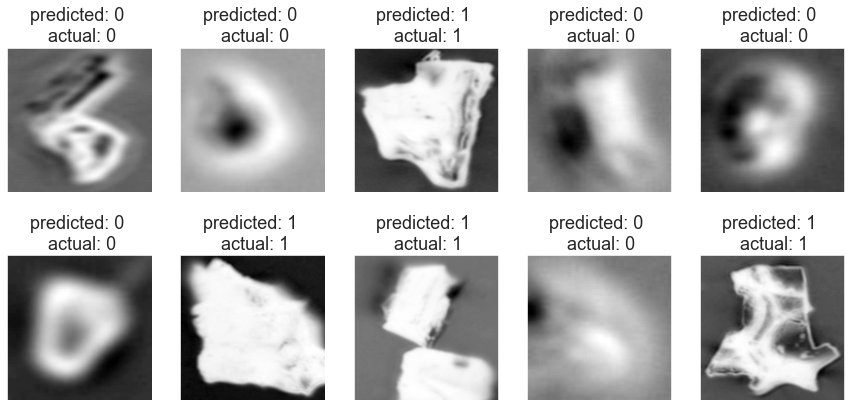

In [59]:
# show first 10 images that were correctly predicted
correct_idx = np.where(predictions == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Wrongly predicted images

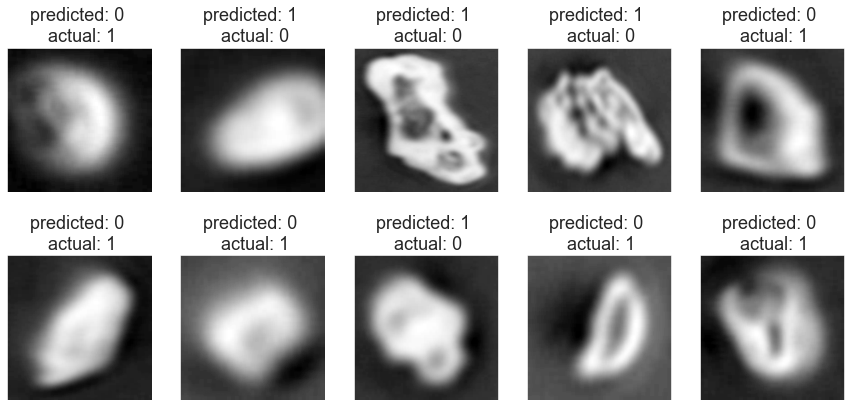

In [60]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(predictions != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(predictions[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)